![image.png](img/crisp-dm.png)

# Framing / Problem Statement / Business Question / Use Case

The company wants to be data driven and request for the data science team to start some projects with the different departments. When the various department heads are asked for business use cases, they groan, Some departments say they have some data that they don't know what Data Science use case to do. After some time speaking with the different departments, you assessed the data they have, and find that many of them a not usable (data not organized, data not recorded properly, too little data etc.). The data science team finally decided to start on a small project with the HR departmnet. Business use cases are discussed:

1. How can we keep our most talented people?
    - compensation?
    - meaningful work?
    - unfair treatment?
    - travel too often?
1. Can we predict who is going to leave before they even tender their resignation?
1. Are we overpaying some people?
1. What are the skillset employees in the company should have?
1. ... ...

Use cases are decided based on:
- which is the most costly? E.g. in terms of `$$$`, in terms of `criticality of a role`
- Which is most urgent?
- Which is achieveable?
- etc.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (eb.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv


In [2]:
from pathlib import Path
from pprint import pprint

In [3]:
filename = Path('./data/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')
output_path = Path('/kaggle/working/')
data_path = output_path / 'data'

for path in [data_path, data_path / 'intermediate', data_path / 'processed']:
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)

# Understand the data

Variables aka predictor, independent variable, X, features

In [4]:
# preview the data to know how does the data look like. Using Linux Skills.
!head -5 /kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv

In [5]:
# Ingest the data
df_raw = pd.read_csv(filename)

df_raw.head()

Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...                         1            80                 0   
1  ...                         4            80                 1   
2  ...                         2            80                 0   
3  ...                         3            80                 0   
4  ...                         4            80                 1   

   TotalWorkingYears  TrainingTimesLastYear WorkLifeBalance  YearsAtCompany  \
0                  8                      0               1               6   
1                 10                      3               3              10   
2                  7                      3               3               0   
3                  8                      3               3               8   
4                  6                      3               3               2   

  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
0                  4                        0                     5  
1                  7                        1                     7  
2                  0                        0                     0  
3                  7                        3                     0  
4                  2                        2                     2  

[5 rows x 35 columns]

In [6]:
nrows, ncols = df_raw.shape
print(f'There are {nrows} rows and {ncols} columns')

There are 1470 rows and 35 columns


## Curse of dimensionality

**Too many variables, too little data.**

aka predictor, independent variable, X, features

You can't observe enough "pattern" of how the outcome change as the variables interact with one another.

How much data is enough for the number of variables?

- Too many features --> overfitting
- Too little features --> underfitting

In [7]:
# column names. Are the columns self explanatory?
pprint(df_raw.columns)

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')


**Do we know what is in the data?**

- This is an attrition use case, we are likely trying to predict `Attrition`.
- Are all columns required for modeling?

In [8]:
# Look at the "spread" of Attrition.
df_raw.Attrition.value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

**Warning** inbalance data - for every 1 who left the company, 5 did not.

| Positive Cases | Negative Cases |
| --- | --- |
| 237 | 1233 |

# Split data into train and test/validation set. 

We do not train the model on all the data because doing so otherwise will cause the model to pick up patterns in the data that occured by chance. We typically split the dataset into 2: training data and test/validation data.
- Training data is for training the machine learning model
- Test/validation data is to provided a estimate of the trained model accuracy, allowing us to pick the best model (we will train at least 2 models for comparison).

Spliting the data:
- Typically in a ratio, `4:1` (1,176 v.s. 294 rows). Ideally, the more training data there are, the better.
- I also want to have an equal number of unique `Yes`s and `No`s in the test set.
    - Due to the limited number of attritions, let's have 50 `Yes` and 50 `No` in the test set, instead for splitting the data into the 4:1 ratio
    
Proposed data splits:
- Train set - 187 `Yes`, 1183 `No`
- Test set - 50 `Yes`, 50 `No`

Balance the data:
- need more `Yes`s in the training set, the same number as `No`s.

Final data count
- Train set - 1183 + 1183 = 2366
- Test set - 100

For 30 rows of data per variables, my target number of variables should be:
- `2366 / 30 < 78.8 variables`

We have 28 variables.

In [9]:
# split into training and testing data
from sklearn.model_selection import train_test_split

df_pos = df_raw[df_raw['Attrition'] == 'Yes']
df_neg = df_raw[df_raw['Attrition'] == 'No']
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(df_pos.drop('Attrition', axis=1),
                                                                    df_pos['Attrition'],
                                                                    test_size=50,
                                                                    random_state=42)
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(df_neg.drop('Attrition', axis=1),
                                                                    df_neg['Attrition'],
                                                                    test_size=50,
                                                                    random_state=42)
X_train = pd.concat([X_train_pos, X_train_neg])
y_train = pd.concat([y_train_pos, y_train_neg])
X_test = pd.concat([X_test_pos, X_test_neg])
y_test = pd.concat([y_test_pos, y_test_neg])

X_train.shape, X_test.shape

((1370, 34), (100, 34))

187 Yes + 1183 No = 1370 rows

# Analyzing the variables in training data

Keep in mind that some of the values in the training data may not be in the test data after the split (vice versa).

In [10]:
# Analyzing Independent Variables
variables = [col for col in df_raw.columns if col != 'Attrition']
print(f'{len(variables)} variables')

with pd.option_context('display.max_columns', None):
    display(X_train[variables].describe())  # only shows the numerical variables.

34 variables


Age    DailyRate  DistanceFromHome    Education  EmployeeCount  \
count  1370.000000  1370.000000       1370.000000  1370.000000         1370.0   
mean     36.983212   803.083212          9.116788     2.909489            1.0   
std       9.193108   404.394737          8.088955     1.028014            0.0   
min      18.000000   102.000000          1.000000     1.000000            1.0   
25%      30.000000   465.250000          2.000000     2.000000            1.0   
50%      36.000000   802.000000          7.000000     3.000000            1.0   
75%      43.000000  1157.000000         14.000000     4.000000            1.0   
max      60.000000  1499.000000         29.000000     5.000000            1.0   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count     1370.000000              1370.000000  1370.000000     1370.000000   
mean      1024.194891                 2.748175    65.774453        2.730657   
std        600.813121                 1.084495    20.409563        0.708713   
min          1.000000                 1.000000    30.000000        1.000000   
25%        491.500000                 2.000000    48.000000        2.000000   
50%       1024.500000                 3.000000    66.000000        3.000000   
75%       1553.750000                 4.000000    84.000000        3.000000   
max       2068.000000                 4.000000   100.000000        4.000000   

          JobLevel  JobSatisfaction  MonthlyIncome   MonthlyRate  \
count  1370.000000      1370.000000    1370.000000   1370.000000   
mean      2.071533         2.746715    6538.387591  14348.841606   
std       1.112710         1.091541    4735.915067   7128.601575   
min       1.000000         1.000000    1009.000000   2094.000000   
25%       1.000000         2.000000    2936.000000   8009.750000   
50%       2.000000         3.000000    4907.500000  14329.000000   
75%       3.000000         4.000000    8389.250000  20484.500000   
max       5.000000         4.000000   19999.000000  26999.000000   

       NumCompaniesWorked  PercentSalaryHike  PerformanceRating  \
count         1370.000000        1370.000000        1370.000000   
mean             2.677372          15.213869           3.151095   
std              2.488454           3.645378           0.358272   
min              0.000000          11.000000           3.000000   
25%              1.000000          12.000000           3.000000   
50%              2.000000          14.000000           3.000000   
75%              4.000000          18.000000           3.000000   
max              9.000000          25.000000           4.000000   

       RelationshipSatisfaction  StandardHours  StockOptionLevel  \
count               1370.000000         1370.0       1370.000000   
mean                   2.705839           80.0          0.789781   
std                    1.077173            0.0          0.839778   
min                    1.000000           80.0          0.000000   
25%                    2.000000           80.0          0.000000   
50%                    3.000000           80.0          1.000000   
75%                    4.000000           80.0          1.000000   
max                    4.000000           80.0          3.000000   

       TotalWorkingYears  TrainingTimesLastYear  WorkLifeBalance  \
count        1370.000000            1370.000000      1370.000000   
mean           11.323358               2.800000         2.762044   
std             7.840994               1.291428         0.698755   
min             0.000000               0.000000         1.000000   
25%             6.000000               2.000000         2.000000   
50%            10.000000               3.000000         3.000000   
75%            15.000000               3.000000         3.000000   
max            40.000000               6.000000         4.000000   

       YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  \
count     1370.000000         1370.000000              1370.

Unimportant numerical variables:
- `EmployeeCount` (no variance), `EmployeeNumber`, `PerformanceRating` (min is 3, max is 4), `StandardHours` (no variance)

Comments
- `Education`, `EnvironmentSatisfaction`, `JobInvolvement`, `JobLevel`, `JobSatisfaction`, `RelationshipSatisfaction`, `StockOptionLevel`, `WorkLifeBalance`,  are likely categorical.
- `HourlyRate` and `DailyRate`, `MonthlyRate` likely correlated. `MonthlyIncome` likely related.


In [11]:
to_cat_cols = ['Education',
               'EnvironmentSatisfaction',
               'JobInvolvement',
               'JobLevel',
               'JobSatisfaction',
               'RelationshipSatisfaction',
               'StockOptionLevel',
               'WorkLifeBalance']
num_cols = [col 
            for col in X_train._get_numeric_data().columns 
            if col not in to_cat_cols]
cat_cols = [col 
            for col in X_train.columns 
            if col not in num_cols]

In [12]:
for col in cat_cols:
    print(col)
    display(df_raw[col].value_counts().sort_index())
    print()

BusinessTravel


Non-Travel            150
Travel_Frequently     277
Travel_Rarely        1043
Name: BusinessTravel, dtype: int64


Department


Human Resources            63
Research & Development    961
Sales                     446
Name: Department, dtype: int64


Education


1    170
2    282
3    572
4    398
5     48
Name: Education, dtype: int64


EducationField


Human Resources      27
Life Sciences       606
Marketing           159
Medical             464
Other                82
Technical Degree    132
Name: EducationField, dtype: int64


EnvironmentSatisfaction


1    284
2    287
3    453
4    446
Name: EnvironmentSatisfaction, dtype: int64


Gender


Female    588
Male      882
Name: Gender, dtype: int64


JobInvolvement


1     83
2    375
3    868
4    144
Name: JobInvolvement, dtype: int64


JobLevel


1    543
2    534
3    218
4    106
5     69
Name: JobLevel, dtype: int64


JobRole


Healthcare Representative    131
Human Resources               52
Laboratory Technician        259
Manager                      102
Manufacturing Director       145
Research Director             80
Research Scientist           292
Sales Executive              326
Sales Representative          83
Name: JobRole, dtype: int64


JobSatisfaction


1    289
2    280
3    442
4    459
Name: JobSatisfaction, dtype: int64


MaritalStatus


Divorced    327
Married     673
Single      470
Name: MaritalStatus, dtype: int64


Over18


Y    1470
Name: Over18, dtype: int64


OverTime


No     1054
Yes     416
Name: OverTime, dtype: int64


RelationshipSatisfaction


1    276
2    303
3    459
4    432
Name: RelationshipSatisfaction, dtype: int64


StockOptionLevel


0    631
1    596
2    158
3     85
Name: StockOptionLevel, dtype: int64


WorkLifeBalance


1     80
2    344
3    893
4    153
Name: WorkLifeBalance, dtype: int64

Remove `Over18`, `MaritalStatus`, `JobRole`

For `MaritalStatus` and `JobRole`, the length of time they had been in that status is probably important, however, this information is not provided.

Food for thought: Shall we analyze attrition by `Department`? `Gender`? `JobSatisfaction`?

In [13]:
# Check that all value in test data is also in training.
for col in cat_cols:
    for value in X_test[col].unique():
        if value not in X_train[col].unique():
            print(f'{value} not in {col}')

In [14]:
cols_to_remove = 'EmployeeCount EmployeeNumber StandardHours Over18 MaritalStatus JobRole PerformanceRating'.split()

num_cols = [col for col in num_cols if col not in cols_to_remove]
cat_cols = [col for col in cat_cols if col not in cols_to_remove]

print(f'number of numerical variables: {len(num_cols)}')
print(f'number of categorical variables: {len(cat_cols)}')

number of numerical variables: 14
number of categorical variables: 13


In [15]:
for col in cat_cols:
    xtab = pd.crosstab(X_train[col], y_train)
    xtab['yes_ratio'] = xtab['Yes'] / xtab[['No', 'Yes']].sum(axis=1)
    display(xtab)
    print('-' * 50)

Attrition           No  Yes  yes_ratio
BusinessTravel                        
Non-Travel         133    8   0.056738
Travel_Frequently  196   58   0.228346
Travel_Rarely      854  121   0.124103

--------------------------------------------------


Attrition                No  Yes  yes_ratio
Department                                 
Human Resources          48   10   0.172414
Research & Development  793  106   0.117909
Sales                   342   71   0.171913

--------------------------------------------------


Attrition   No  Yes  yes_ratio
Education                     
1          133   28   0.173913
2          228   35   0.133080
3          455   75   0.141509
4          326   45   0.121294
5           41    4   0.088889

--------------------------------------------------


Attrition          No  Yes  yes_ratio
EducationField                       
Human Resources    19    5   0.208333
Life Sciences     492   61   0.110307
Marketing         119   29   0.195946
Medical           385   55   0.125000
Other              71   10   0.123457
Technical Degree   97   27   0.217742

--------------------------------------------------


Attrition                 No  Yes  yes_ratio
EnvironmentSatisfaction                     
1                        200   53   0.209486
2                        233   29   0.110687
3                        379   53   0.122685
4                        371   52   0.122931

--------------------------------------------------


Attrition   No  Yes  yes_ratio
Gender                        
Female     477   69   0.126374
Male       706  118   0.143204

--------------------------------------------------


Attrition        No  Yes  yes_ratio
JobInvolvement                     
1                53   23   0.302632
2               293   57   0.162857
3               714   97   0.119605
4               123   10   0.075188

--------------------------------------------------


Attrition   No  Yes  yes_ratio
JobLevel                      
1          385  118   0.234592
2          461   38   0.076152
3          177   24   0.119403
4           98    3   0.029703
5           62    4   0.060606

--------------------------------------------------


Attrition         No  Yes  yes_ratio
JobSatisfaction                     
1                210   45   0.176471
2                230   38   0.141791
3                356   60   0.144231
4                387   44   0.102088

--------------------------------------------------


Attrition   No  Yes  yes_ratio
OverTime                      
No         906   83   0.083923
Yes        277  104   0.272966

--------------------------------------------------


Attrition                  No  Yes  yes_ratio
RelationshipSatisfaction                     
1                         213   44   0.171206
2                         246   38   0.133803
3                         377   57   0.131336
4                         347   48   0.121519

--------------------------------------------------


Attrition          No  Yes  yes_ratio
StockOptionLevel                     
0                 458  126   0.215753
1                 520   43   0.076377
2                 140   10   0.066667
3                  65    8   0.109589

--------------------------------------------------


Attrition         No  Yes  yes_ratio
WorkLifeBalance                     
1                 50   19   0.275362
2                278   51   0.155015
3                734   97   0.116727
4                121   20   0.141844

--------------------------------------------------


# Feature selection and engineering
- Create new features from existing ones.
    1. merge values in a feature. E.g. in the Department variable.
    2. add/subtract/multiple/divide/ features together to form a new one. e.g. weight / height^2 = BMI
    3. Apply some math operations to existing feature. e.g. log
    4. Part of an existing feature. e.g. the month of a date.
    5. ... ...

Various reasons to accept or reject a feature.
- Are the features actionable?
- Is there 1 group with a large proportion of the employees?
- Any variables that makes more sense and that we can derive from existing ones?

| Features | Reason | New features |
| -------- | ------ | ------------ |
| Department | majority in R&D (~2/3) and it has a much lower attrition rate. Merge the other departments together. If department is the reason for attrition, then perhaps this insight is actionable | department_new | 

| Type | Eliminate | Reasons |
| ---- | --------- | ------- |
| Categorical | EducationField | future work |
| Categorical | EnvironmentSatisfaction | Attrition risk. Gather feedback about the environment. |
| Categorical | JobInvolvement | Attrition Risk. Interview people who score this low. Actionable by managers. |
| Categorical | JobSatisfaction | Actionable by managers, not so much HR. |
| Categorical | StockOptionLevel | Let's avoid compensation related for now. |
| Categorical | RelationshipSatisfaction | Actionable by managers, not so much HR. |
| Numerical | DailyRate | Let's avoid compensation related for now. |
| Numerical | DistanceFromHome | Not actionable |
| Numerical | HourlyRate | Let's avoid compensation related for now. |
| Numerical | MonthlyIncome | Let's avoid compensation related for now. |
| Numerical | MonthlyRate | Let's avoid compensation related for now. |
| Numerical | NumCompaniesWorked | Not actionable |
| Numerical | PercentSalaryHike | Let's avoid compensation related for now. |
| Numerical | TotalWorkingYears | Not actionable |
| Numerical | YearsWithCurrManager | Not actionable |

In [16]:
# Department = 'Research & Development'

cat_to_remove = ['EducationField',
 'EnvironmentSatisfaction',
 'JobInvolvement',
 'JobSatisfaction',
 'StockOptionLevel',
 'RelationshipSatisfaction']

num_to_remove = ['DailyRate',
 'DistanceFromHome',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'YearsWithCurrManager']

In [17]:
cat_cols = [col for col in cat_cols if col not in cat_to_remove]
print('Number of categorical features:', len(cat_cols))
print('----------------')
num_cols = [col for col in num_cols if col not in num_to_remove]
print('Number of numerical features:', len(num_cols))

print(f'Total number of features: {len(cat_cols + num_cols)}')

Number of categorical features: 7
----------------
Number of numerical features: 5
Total number of features: 12


In [18]:
relabel_department = lambda x: 'R&D' if x == 'Research & Development' else 'Sales/HR'
X_train['Department'] = X_train['Department'].map(relabel_department)
X_test['Department'] = X_test['Department'].map(relabel_department)

Explore numerical variables.

- any highly correlated variables?

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

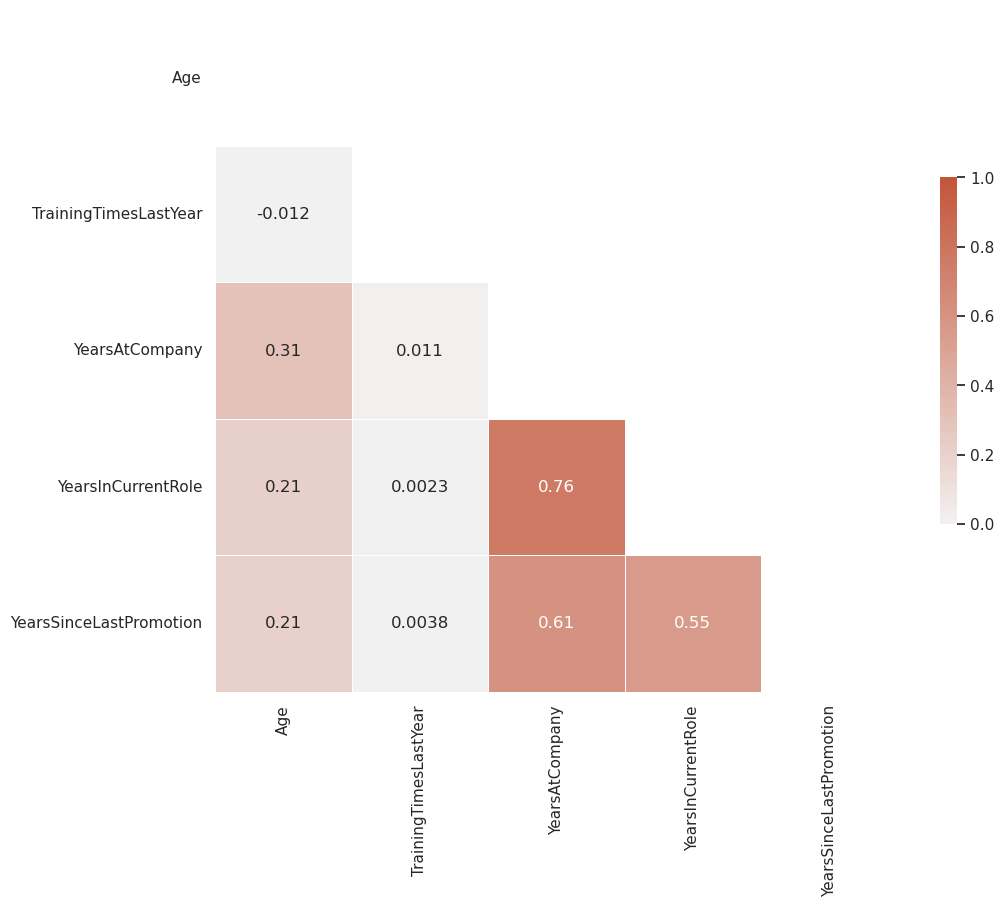

In [20]:
corr = X_train[num_cols].corr()
sns.set(style="white")
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=0, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
plt.show()

`YearsInCurrentRole`, `YearsAtCompany` and `YearsSinceLastPromotion` are moderately to strongly correlated.

Will remove `YearsAtCompany` as this variable is less actionable.

In [21]:
num_cols = [col for col in num_cols if col != 'YearsAtCompany']

## Numerical Data preprocessing

Some models may need the numerical data to be scaled, for example, distance based models like clustering.

In [22]:
# Example
# normalize the numerical columns
# Using min-max normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X_train[num_cols])

## Categorical Data preprocessing

Values has to be converted to numbers.

In [23]:
X_train[cat_cols].apply('nunique')

BusinessTravel     3
Department         2
Education          5
Gender             2
JobLevel           5
OverTime           2
WorkLifeBalance    4
dtype: int64

In [24]:
X_train.JobLevel.value_counts()

1    503
2    499
3    201
4    101
5     66
Name: JobLevel, dtype: int64

**Do the numbers in `JobLevel`** mean anything mathematically?

In [25]:
def ohe_preprocessing(df, expected_columns: list=None):
    ohe_df = pd.DataFrame()
    for col in df.columns:
        tmp_df = pd.get_dummies(df[col], prefix=col)
        if df[col].nunique() == 2:
            ohe_df = pd.concat([ohe_df, tmp_df[tmp_df.columns[:1]]],
                               axis=1)
        else:
            ohe_df = pd.concat([ohe_df, tmp_df],
                               axis=1)
            
    if expected_columns:
        for col in expected_columns:
            if col not in ohe_df.columns:
                ohe_df.loc[:, col] = 0
        return ohe_df[expected_columns]
    else:
        return ohe_df
        

In [26]:
X_train_ohe = ohe_preprocessing(X_train[cat_cols], expected_columns=None)
display(X_train_ohe)
X_train_preprocessed = pd.concat([X_train_ohe, X_train[num_cols]], axis=1)
assert X_train_preprocessed.isnull().sum().max() == 0
assert len(X_train_preprocessed) == len(X_train)


BusinessTravel_Non-Travel  BusinessTravel_Travel_Frequently  \
1395                          0                                 1   
608                           0                                 0   
1153                          0                                 1   
547                           0                                 1   
947                           0                                 0   
...                         ...                               ...   
1248                          0                                 0   
1311                          1                                 0   
1355                          0                                 0   
1035                          0                                 0   
1349                          0                                 0   

      BusinessTravel_Travel_Rarely  Department_R&D  Education_1  Education_2  \
1395                             0               0            0            0   
608                              1               0            1            0   
1153                             0               0            0            1   
547                              0               1            0            0   
947                              1               0            0            0   
...                            ...             ...          ...          ...   
1248                             1               1            0            0   
1311                             0               1            0            0   
1355                             1               0            0            1   
1035                             1               0            0            1   
1349                             1               1            0            1   

      Education_3  Education_4  Education_5  Gender_Female  JobLevel_1  \
1395            0            1            0              0           0   
608             0            0            0              0           0   
1153            0            0            0              1           1   
547             1            0            0              0           1   
947             1            0            0              0           0   
...           ...          ...          ...            ...         ...   
1248            1            0            0              1           1   
1311            1            0            0              1           1   
1355            0            0            0              0           0   
1035            0            0            0              1           1   
1349            0            0            0              1           1   

      JobLevel_2  JobLevel_3  JobLevel_4  JobLevel_5  OverTime_No  \
1395           1           0           0           0            0   
608            1           0           0           0            1   
1153           0           0           0           0            0   
547            0           0           0           0            0   
947            0           1           0           0            0   
...          ...         ...         ...         ...          ...   
1248           0           0           0           0            1   
1311           0           0           0           0            1   
1355           1           0           0           0            1   
1035           0           0           0           0            1   
1349           0           0           0           0            0   

      WorkLifeBalance_1  WorkLifeBalance_2  WorkLifeBalance_3  \
1395                  0                  0                  1   
608                   0                  1                  0   
1153                  0                  0                  0   
547                   0                  0                  1   
947                   0                  1                  0   
...                 ...                ...                ...   
1248                  0                  1 

In [27]:
y_encoder = lambda y: 1 if y == 'Yes' else 0
y_train_preprocessed = y_train.map(y_encoder)
assert y_train_preprocessed.isnull().sum().max() == 0
assert len(y_train_preprocessed) == len(X_train)
y_train_preprocessed.value_counts()


0    1183
1     187
Name: Attrition, dtype: int64

In [28]:
import numpy as np

In [29]:
neg_ct, pos_ct = y_train_preprocessed.value_counts().tolist()
index_array = np.arange(pos_ct)

np.random.seed(2023)
samples = np.random.choice(index_array,
                           size=neg_ct - pos_ct, replace=True)
y_additional_samples = y_train_preprocessed[y_train_preprocessed == 1].iloc[samples].reset_index(drop=True)

X_additional_samples = X_train_preprocessed[y_train_preprocessed == 1].iloc[samples].reset_index(drop=True)

y_train_preprocessed_sampled = pd.concat([y_train_preprocessed,
                                  y_additional_samples])
X_train_preprocessed_sampled = pd.concat([X_train_preprocessed, X_additional_samples])

In [30]:
assert (y_train_preprocessed_sampled == 1).sum() == \
(y_train_preprocessed_sampled == 0).sum()

In [31]:
def preprocess(X, y, scaler=None, expected_columns=None):
    if scaler is not None:
        X[num_cols] = scale.transform(X[num_cols])
    X_ohe = ohe_preprocessing(X[cat_cols], expected_columns=expected_columns)
    X_preprocessed = pd.concat([X_ohe, X[num_cols]], axis=1)
    assert X_preprocessed.isnull().sum().max() == 0
    assert len(X_preprocessed) == len(X)
    
    y_preprocessed = y.map(y_encoder)
    assert y_preprocessed.isnull().sum().max() == 0
    assert len(y_preprocessed) == len(y)
    
    return X_preprocessed, y_preprocessed

X_test, y_test = preprocess(X_test, y_test,
                            expected_columns=X_train_ohe.columns.tolist())

In [32]:
y_test.value_counts()

1    50
0    50
Name: Attrition, dtype: int64

# Modeling

Basic classifiers
1. Logistic regression
1. Decision Tree

## LogisticRegression

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
lr = LogisticRegression(max_iter=500)

lr.fit(X_train_preprocessed_sampled, y_train_preprocessed_sampled)
pred = lr.predict(X_test)

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.65


In [35]:
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(confusion)
    ax.grid(False)
    ax.set_xlabel('Predicted outputs', fontsize=12, color='black')
    ax.set_ylabel('Actual outputs', fontsize=12, color='black')
    ax.xaxis.set(ticks=range(2))
    ax.yaxis.set(ticks=range(2))
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_yticklabels(['No', 'Yes'])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, confusion[i, j], ha='center', va='center', color='white')
    plt.show()

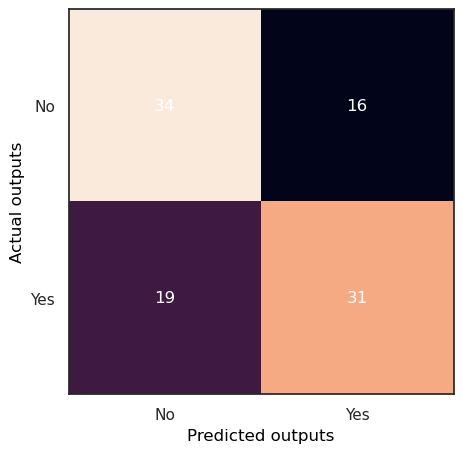

In [36]:
show_confusion_matrix(y_test, pred)

## Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier

Accuracy: 0.61


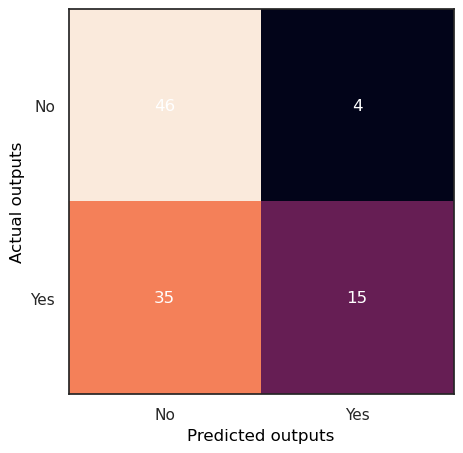

In [38]:
tree = DecisionTreeClassifier()

tree.fit(X_train_preprocessed_sampled, y_train_preprocessed_sampled)
pred = tree.predict(X_test)

accuracy = accuracy_score(y_test, pred)
print(f"Accuracy: {accuracy}")
show_confusion_matrix(y_test, pred)

# Result: LogisticRegression v.s. Decision Tree

**Accuracy**
LogisticRegression (0.65) > Decision Tree (0.61)

- Out of 50 attritions, LogisticRegression is able to predict 31 compared to 15 by the decision tree model.
- Decision Tree is able to predict employees who stayed well (46 out of 50).
- Prediction from logistic regression is less bias towards an outcome.

# Model Explanation

In [39]:
import math

In [40]:
def convert_coefficient_to_probability(coef):
    # odds ratio is defined as the ratio of 
    # the odds of attrition in the presence of B and
    # the odds of attrition in the absence of B    
    # An odds_ratio more than 1 means a more likelihood for leaving.
    odds_ratio = math.exp(coef)
    
    return odds_ratio

In [41]:
sorted_arr = np.argsort(lr.coef_[0])

intercept = lr.intercept_[0]
print(intercept)
for index in sorted_arr:
    coeff = lr.coef_[0][index]
    odds_ratio = convert_coefficient_to_probability(coeff)
    print(f'{X_train_preprocessed_sampled.columns[index]}: is {odds_ratio} more likely to leave.')

2.990303506283897
JobLevel_4: is 0.14940037399277317 more likely to leave.
OverTime_No: is 0.24369401410762728 more likely to leave.
Department_R&D: is 0.41492027910871443 more likely to leave.
BusinessTravel_Non-Travel: is 0.4351332076047787 more likely to leave.
WorkLifeBalance_3: is 0.6290225884505293 more likely to leave.
WorkLifeBalance_4: is 0.7072606452197192 more likely to leave.
TrainingTimesLastYear: is 0.8111443049248537 more likely to leave.
JobLevel_2: is 0.8132912608487379 more likely to leave.
Gender_Female: is 0.8240395683153254 more likely to leave.
YearsInCurrentRole: is 0.8638318300538997 more likely to leave.
Education_3: is 0.8741855461345898 more likely to leave.
Education_4: is 0.9068216014817374 more likely to leave.
BusinessTravel_Travel_Rarely: is 0.9697748182130177 more likely to leave.
Age: is 0.973942075085469 more likely to leave.
WorkLifeBalance_2: is 0.9931321494033443 more likely to leave.
Education_2: is 1.0520820524973449 more likely to leave.
Educati

**Risk factor for leaving is higher when the value is more than 1**:

E.g. 
- For every 1 `YearsSinceLastPromotion`, the chance of leaving is 1.14 times higher.

Other findings.
- Employees in `JobLevel 1`, `5` and `3` have 2.53, 1.85 and 1.73 higher change of leaving
- Employees view `WorkLifeBalance` as important. Especially take note of employees who rated `WorkLifeBalance` 1 (2.22 more likelihood of leaving).
- `BusinessTravel_Travel_Frequently` is a risk factor. Are employees in `JobLevel_3` and `JobLevel_5` tend to `BusinessTravel_Travel_Frequently` as well?
    - candidate for feature engineering both JobLevel and BusinessTravel to provide more insights.

Time and effort may be required in the future to further improve the model.

Topics not covered:
- Different model evaluation metrics
- regularization to reduce overfitting.
- variance and bias.
- forward and backward stepwise selection.
- R-score and adjusted R-score
- dimensionality reduction.
- Blackbox algorithms/models.
- Data Augmentation
- Cross Validation